In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Jul 30 15:33:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    28W /  70W |   9312MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
!git clone https://github.com/Vela-Yang/vela_SR.git SR

fatal: destination path 'SR' already exists and is not an empty directory.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import torch
import torchvision
from SR.models import AVS3Filter
from SR.dataset import VelaDataset
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
from tqdm.notebook import tqdm


# 是否有GPU加速
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == "cuda":
    num_workers = 16
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False
print(device)

cuda


In [2]:
# 加载网络模型
model = AVS3Filter().to(device)


# 损失函数
loss_fun = torch.nn.MSELoss().to(device)
losses = []
losses_test = []

# 数据集加载
#train_set = VelaDataset(root="./drive/MyDrive/iaprtc12/", number_of_files=19140, size_of_crop=48, subset="training")
#test_set = VelaDataset(root="./drive/MyDrive/iaprtc12/", number_of_files=19140, size_of_crop=48, subset="testing")

In [6]:
# 优化器
optimizer = torch.optim.Adam(model.parameters())
# 批大小
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)
test_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    pin_memory=pin_memory
)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [7]:
# 训练函数
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (y, y_lr) in enumerate(train_loader):
        y, y_lr = y.to(device, torch.float), y_lr.to(device, torch.float)
        output = model(y_lr/ 255)
        loss = loss_fun(output, y/ 255)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 展示训练状态
        if batch_idx % log_interval == 0:
            print(
                f"迭代次数: {epoch} [{batch_idx * len(y_lr)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\t训练损失: {loss.item():.6f}")
        # 更新状态栏
        pbar.update(pbar_update)
        # 记录训练损失
        losses.append(loss.item())


# 测试
def test(model, epoch):
    model.eval()
    for y, y_lr in test_loader:
        y_lr, y = y_lr.to(device, torch.float), y.to(device, torch.float)
        output = model(y_lr / 255)
        loss = loss_fun(output, y / 255)
        losses_test.append(loss.item())
        # 更新状态栏
        pbar.update(pbar_update)
    print(f"\n迭代次数 {epoch}\t训练损失: {loss.item():.6f}")


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


迭代次数: 1 [0/11480 (0%)]	训练损失: 0.418291
迭代次数: 1 [1280/11480 (11%)]	训练损失: 0.403918
迭代次数: 1 [2560/11480 (22%)]	训练损失: 0.380008
迭代次数: 1 [3840/11480 (33%)]	训练损失: 0.360382
迭代次数: 1 [5120/11480 (44%)]	训练损失: 0.343983
迭代次数: 1 [6400/11480 (56%)]	训练损失: 0.323982
迭代次数: 1 [7680/11480 (67%)]	训练损失: 0.308859
迭代次数: 1 [8960/11480 (78%)]	训练损失: 0.291196
迭代次数: 1 [10240/11480 (89%)]	训练损失: 0.277947

迭代次数 1	训练损失: 0.328445
迭代次数: 2 [0/11480 (0%)]	训练损失: 0.257963
迭代次数: 2 [1280/11480 (11%)]	训练损失: 0.246358
迭代次数: 2 [2560/11480 (22%)]	训练损失: 0.232783
迭代次数: 2 [3840/11480 (33%)]	训练损失: 0.221080
迭代次数: 2 [5120/11480 (44%)]	训练损失: 0.208898
迭代次数: 2 [6400/11480 (56%)]	训练损失: 0.196089
迭代次数: 2 [7680/11480 (67%)]	训练损失: 0.183348
迭代次数: 2 [8960/11480 (78%)]	训练损失: 0.172088
迭代次数: 2 [10240/11480 (89%)]	训练损失: 0.164048

迭代次数 2	训练损失: 0.170397
迭代次数: 3 [0/11480 (0%)]	训练损失: 0.153073
迭代次数: 3 [1280/11480 (11%)]	训练损失: 0.145192
迭代次数: 3 [2560/11480 (22%)]	训练损失: 0.134854
迭代次数: 3 [3840/11480 (33%)]	训练损失: 0.128587
迭代次数: 3 [5120/11480 (44%)]	训练损失: 0.11848

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35757 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32451 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25439 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22833 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 35757 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 32451 missing from current font.
  font.set_te

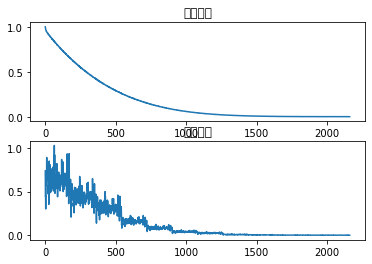

In [12]:

n_epoch = 10
log_interval = 20
pbar_update = 1 / (len(train_loader) + len(test_loader))

with tqdm(total=n_epoch) as pbar:   
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)

# 展示训练损失与准确率
plt.subplot(2, 1, 1)
plt.plot(losses);
plt.title("训练损失");
plt.subplot(2, 1, 2)
plt.plot(losses_test);
plt.title("测试损失");



In [14]:
torch.save(model.state_dict(), '1.pth')
torch.save(model, '1.pkl') 